Credit: *Axel Guinot* for all simulations from `descwl_shear_sims`, *Ismael Mendoza* functions for HMC using `jax_galsim`.

# Setup

In [198]:
import numpy as np

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
from descwl_shear_sims.galaxies import make_galaxy_catalog
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.objlists import get_objlist
from descwl_shear_sims.surveys import get_survey
from descwl_shear_sims.constants import FIXED_PSF_FWHM, SCALE

import metadetect

import matplotlib.pyplot as plt

import galsim

import gc


In [199]:
import numpy as np
import descwl_shear_sims
import lsst.afw
import matplotlib.pyplot as plt 

import jax
import jax.numpy as jnp
import jax_galsim as galaxim


In [200]:
jax.devices()


[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [201]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


In [202]:
def get_coadd_center_gs_pos(coadd_wcs, coadd_bbox):
    """
    get the sky position of the center of the coadd within the
    bbox as a galsim CelestialCoord

    Parameters
    ----------
    coadd_wcs: DM wcs
        The wcs for the coadd
    coadd_bbox: geom.Box2I
        The bounding box for the coadd within larger wcs system

    Returns
    -------
    galsim CelestialCoord
    """

    # world origin is at center of the coadd, which itself
    # is in a bbox shifted from the overall WORLD_ORIGIN

    bbox_cen_skypos = coadd_wcs.pixelToSky(
        coadd_bbox.getCenter()
    )

    return galsim.CelestialCoord(
        ra=float(bbox_cen_skypos.getRa()) * galsim.radians,
        dec=float(bbox_cen_skypos.getDec()) * galsim.radians,
)


## Setup data

In [203]:
seed = 8317
rng = np.random.RandomState(seed)
# COADD_DIM = 111
# N_OBJECTS = 16
COADD_DIM = 251
# N_OBJECTS = 25
# COADD_DIM = 201
# N_OBJECTS = 4
PSF_DIM = 51
bands = ['i']
NOISE_FACTOR = 1
GAL_HLR = 0.8 


# this makes a grid of fixed exponential galaxies
# with default properties. One exposure per band

galaxy_catalog = make_galaxy_catalog(
    rng=rng,
    gal_type='fixed',
    coadd_dim=COADD_DIM,
    buff=20,
    layout='random',
    gal_config={"morph": "exp", "mag": 22, 'hlr':GAL_HLR}
)
survey = get_survey(gal_type=galaxy_catalog.gal_type, band=bands[0])
noise_for_gsparams = survey.noise*NOISE_FACTOR
NOISE = noise_for_gsparams
lists = get_objlist(
    galaxy_catalog=galaxy_catalog,
    survey=survey,
    star_catalog=None,
    noise=noise_for_gsparams,
)
# gaussian psf
psf = make_fixed_psf(psf_type='gauss')


In [204]:
lists['objlist'][0].half_light_radius, lists['objlist'][0].flux, np.log10(lists['objlist'][0].flux)


(0.8, 1584.893192461114, 3.2)

In [205]:
assert np.log10(lists['objlist'][0].flux) > 3 and np.log10(lists['objlist'][0].flux) < 6
assert psf.fwhm == FIXED_PSF_FWHM

In [206]:
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=COADD_DIM,
    psf_dim=PSF_DIM,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=False,
    rotate=False,
    se_dim=COADD_DIM,
    noise_factor=NOISE_FACTOR,
)


In [207]:
se_wcs = data['se_wcs'][0]
coadd_gs_center = get_coadd_center_gs_pos(data['coadd_wcs'], data['coadd_bbox'])
obj_x = []
obj_y = []
for shift in lists['shifts']:
    shift = shift.shear(galsim.Shear(g1=0.02, g2=0.))
    w_pos = coadd_gs_center.deproject(shift.x*galsim.arcsec, shift.y*galsim.arcsec)
    image_pos = se_wcs.toImage(w_pos)
    obj_x.append(image_pos.x)
    obj_y.append(image_pos.y)
obj_x = np.array(obj_x)
obj_y = np.array(obj_y)


In [208]:
def _coadd_sim_data(rng, sim_data, nowarp, remove_poisson):
    """
    copied from mdet-lsst-sim
    """
    from descwl_coadd.coadd import make_coadd
    from descwl_coadd.coadd_nowarp import make_coadd_nowarp
    from metadetect.lsst.util import extract_multiband_coadd_data

    bands = list(sim_data['band_data'].keys())

    if nowarp:
        exps = sim_data['band_data'][bands[0]]

        if len(exps) > 1:
            raise ValueError('only one epoch for nowarp')

        coadd_data_list = [
            make_coadd_nowarp(
                exp=exps[0],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    else:
        coadd_data_list = [
            make_coadd(
                exps=sim_data['band_data'][band],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                coadd_wcs=sim_data['coadd_wcs'],
                coadd_bbox=sim_data['coadd_bbox'],
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    return extract_multiband_coadd_data(coadd_data_list)


In [209]:
def get_psf(exp):

    from metadetect.lsst.util import get_integer_center

    wcs = exp.getWcs()
    bbox = exp.getBBox()

    # this is to be consistent with the coadd code
    cen, _ = get_integer_center(
        wcs=wcs,
        bbox=bbox,
        as_double=True,
    )
    cen_gs = galsim.PositionD(x=cen.x, y=cen.y)

    psf_obj = exp.getPsf()
    psf_image = psf_obj.computeKernelImage(cen).array

    coadd_wcs = make_coadd_wcs(wcs, bbox)

    psf_gs = galsim.InterpolatedImage(
        galsim.Image(psf_image, wcs=coadd_wcs)
    )

    local_wcs = coadd_wcs.local(cen_gs)

    pixel = local_wcs.toWorld(galsim.Pixel(scale=1))
    pixel_inv = galsim.Deconvolve(pixel)

    psf_gs_no_pixel = galsim.Convolve([psf_gs, pixel_inv])

    return psf_gs_no_pixel


In [210]:
data


{'band_data': {'i': [<lsst.afw.image._exposure.ExposureF at 0x7f734c21f2b0>]},
 'coadd_wcs': FITS standard SkyWcs:
 Sky Origin: (200.0000000000, +0.0000000000)
 Pixel Origin: (1624, 1624)
 Pixel Scale: 0.2 arcsec/pixel,
 'psf_dims': (51, 51),
 'coadd_dims': (251, 251),
 'coadd_bbox': Box2I(corner=Point2I(1000, 450), dimensions=Extent2I(251, 251)),
 'bright_info': array([], dtype=int64),
 'se_wcs': [galsim.GSFitsWCS(_data = ['TAN', array([126.0, 126.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.4911423480046486, coord.radians), coord.Angle(-0.0010171386331415655, coord.radians)), None, None, None])]}

In [211]:
mb_coadd = _coadd_sim_data(np.random.RandomState(42), data, True, False)


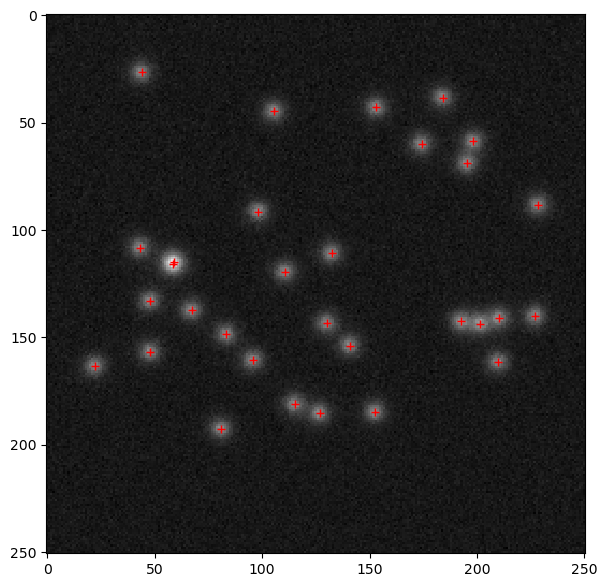

In [212]:
plt.figure(figsize=(7, 7))
plt.imshow(mb_coadd['mbexp']['i'].image.array, cmap='gray', interpolation='nearest')
plt.plot(obj_x-1, obj_y-1, 'r+')
#plt.plot(lists['shifts'][0].x, lists['shifts'][0].y, 'g+')
plt.show()


# Model and Inference

In [213]:
def make_coadd_wcs(coadd_dm_wcs, coadd_dm_bbox):
    """
    make and return a wcs object

    NOTE: copy of make_wcs

    Parameters
    ----------

    Returns
    -------
    A galsim wcs object, currently a TanWCS
    """

    scale = coadd_dm_wcs.getPixelScale().asArcseconds()

    w_orig = coadd_dm_wcs.getSkyOrigin()
    ra = w_orig.getRa().asDegrees()
    dec = w_orig.getDec().asDegrees()
    world_origin = galsim.CelestialCoord(
        ra=ra*galsim.degrees,
        dec=dec*galsim.degrees,
    )

    coadd_dims = [coadd_dm_bbox.height, coadd_dm_bbox.width]
    coadd_cen = (np.array(coadd_dims)-1)/2
    image_origin = galsim.PositionD(x=coadd_cen[1], y=coadd_cen[0])
    

    mat = np.array(
        [[scale, 0.0],
         [0.0, scale]],
    )

    return galsim.TanWCS(
        affine=galsim.AffineTransform(
            mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1],
            origin=image_origin,
        ),
        world_origin=world_origin,
        units=galsim.arcsec,
    )


In [214]:
coadd_img = mb_coadd['mbexp']['i'].image.array
# psf_gs_no_pix = get_psf(mb_coadd['mbexp']['i'])
psf_gs_no_pix = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
# coadd_img = data['band_data']['i'][0].image.array
inv_var = 1.  # /data['band_data']['i'][0].variance.array
POS = np.array([obj_x, obj_y]).T
coadd_wcs = data['coadd_wcs']
coadd_bbox = data['coadd_bbox']


In [215]:
# plt.imshow(coadd_img[:20, :50]), coadd_img[:20, :50].mean(), coadd_img[:20, :50].std()


In [216]:
# coadd metadata setup
COADD_WCS = make_coadd_wcs(coadd_wcs, coadd_bbox)


In [217]:
len(lists['shifts']), lists['shifts']


(31,
 [galsim.PositionD(x=9.651976018677516, y=-13.285769108956142),
  galsim.PositionD(x=11.569856356589447, y=-17.693473902217765),
  galsim.PositionD(x=16.716442257657647, y=3.294378574676319),
  galsim.PositionD(x=-15.13965606404512, y=1.6341406635545859),
  galsim.PositionD(x=-3.8035162871244275, y=-16.375024787757127),
  galsim.PositionD(x=-2.8239266389138074, y=-1.1539541256034553),
  galsim.PositionD(x=13.247186215084113, y=3.5838613319776904),
  galsim.PositionD(x=13.794978934454612, y=-11.438926156202207),
  galsim.PositionD(x=-5.241120847937106, y=-6.863155847067777),
  galsim.PositionD(x=3.0818884869691985, y=5.878248974370642),
  galsim.PositionD(x=5.525313795079949, y=-16.75108512678403),
  galsim.PositionD(x=5.4028448464130605, y=12.16559570380133),
  galsim.PositionD(x=1.0103700653051995, y=3.7285041683062197),
  galsim.PositionD(x=-8.179323315319285, y=4.78921832434164),
  galsim.PositionD(x=20.01238893612794, y=3.063848784434146),
  galsim.PositionD(x=-16.061007639585

In [218]:
# 
# PSF = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
# SHIFTS = [s.shear(galsim.Shear(g1=0.02,g2=0.))/SCALE for s in lists['shifts']]

# @jax.jit
# def draw_gal(x, y, hlr, f, g1, g2):
#     pos = galaxim.PositionD(x=x,y=y)
#     gal = galaxim.Exponential(flux = flux, half_light_radius=hlr)
#     gal = gal.shear(g1=g1, g2=g2)
#     obj = galaxim.Convolve([gal, psf_gs_no_pix]).withGSParams(GSPARAMS)
#     return obj.drawImage(nx=COADD_DIM, ny=COADD_DIM, offset=image_pos, scale=SCALE)
    

# @jax.jit
# def draw_model(x_shifts, y_shifts, hlrs, fluxes, g1, g2):
#     x = jnp.array([s.x - x_shifts[ii] for ii,s in enumerate(SHIFTS)])
#     y = jnp.array([s.y - y_shifts[ii] for ii,s in enumerate(SHIFTS)])
#     stamps = draw_gal(x, y, hlrs, fluxes, g1, g2)

        


#         image += stamp
        
        
#     return image.array


In [219]:
GSPARAMS = galaxim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_model(xs, ys, hlrs, fluxes, g1, g2):

    psf_gs_no_pix = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
    image = galaxim.Image(COADD_DIM, COADD_DIM, scale=SCALE)
    for ii in range(N_OBJECTS):
        shift = lists['shifts'][ii]#arcsec 
        shift = shift.shear(galsim.Shear(g1=0.02, g2=0.))
        pos = shift / SCALE
        
        pos = galaxim.PositionD(pos.x, pos.y)
        x = xs[ii]
        y = ys[ii]
        hlr = hlrs[ii]
        flux = fluxes[ii]

        shift = galaxim.PositionD(x=x,y=y)
        image_pos = pos - shift
        gal = galaxim.Exponential(flux = flux, half_light_radius=hlr)
        gal = gal.shear(g1=g1, g2=g2)

        obj = galaxim.Convolve([gal, psf_gs_no_pix]).withGSParams(GSPARAMS)
        stamp = obj.drawImage(nx=COADD_DIM, ny=COADD_DIM, offset=image_pos, scale=SCALE)
        image += stamp
        
        
    return image.array


In [220]:
def prob_model(y=None):
    g1 = numpyro.sample('g1', dist.Uniform(-0.07, 0.07))
    g2 = numpyro.sample('g2', dist.Uniform(-0.07, 0.07))
    with numpyro.plate('gals', N_OBJECTS, dim=-1):
        fluxes = 10**numpyro.sample('f', dist.Uniform(2.5, 6))
        hlrs = numpyro.sample('hlr', dist.Uniform(0.5, 1.0))
        xs = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        ys = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
    im = draw_model(xs, ys, hlrs, fluxes, g1, g2)
    numpyro.sample('obs', dist.Normal(im, 1.), obs=y)


In [221]:
np.log10(lists['objlist'][0].flux), lists['objlist'][0].half_light_radius


(3.2, 0.8)

In [222]:
TRUTH_IMAGE = mb_coadd['mbexp']['i'].image.array


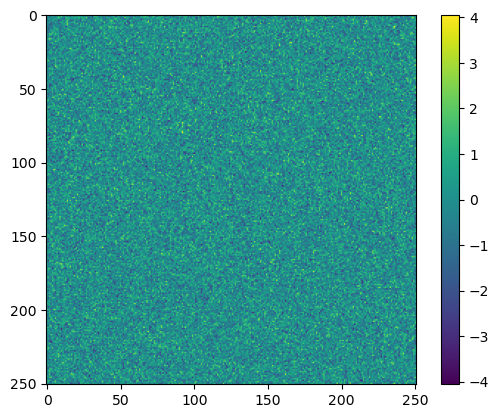

In [223]:
# truth check? 
N_OBJECTS = len(lists['shifts'])
xs = jnp.zeros(N_OBJECTS)
ys = jnp.zeros(N_OBJECTS)
hlrs = jnp.array([GAL_HLR]*N_OBJECTS)
fluxes = jnp.array([lists['objlist'][0].flux]*N_OBJECTS)
g1 = jnp.array([0.02])
g2 = jnp.array([0.00])
arr = draw_model(xs, ys, hlrs, fluxes, g1, g2)
plt.imshow(TRUTH_IMAGE - arr)

# fig, axes = plt.subplots(1, 3, figsize=(11, 5))
# axes[0].imshow(TRUTH_IMAGE)
# axes[1].imshow(arr)
# axes[2].imshow(TRUTH_IMAGE - arr)

# axes[0].plot(obj_x-1, obj_y-1, 'r+')
# axes[1].plot(obj_x-1, obj_y-1, 'r+')
plt.colorbar()


In [224]:
nuts_kernel = NUTS(prob_model, max_tree_depth=10) 
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, y=TRUTH_IMAGE)


warmup:  11%|█         | 332/3000 [08:27<1:07:54,  1.53s/it, 1023 steps of size 6.26e-03. acc. prob=0.78]


KeyboardInterrupt: 

In [164]:
samples = mcmc.get_samples()


In [165]:
samples['g1'].shape

(2000,)

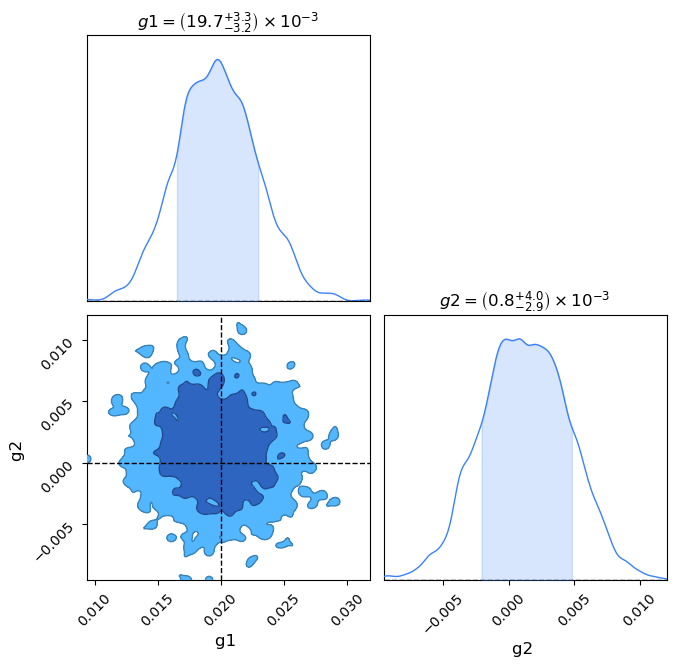

In [169]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
samples = {k:samples[k] for k in ['g1', 'g2']}
df =pd.DataFrame.from_dict(samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g1':0.02, 'g2':0.0}))
fig = c.plotter.plot()

In [168]:
mcmc.print_summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      3.20      0.00      3.20      3.20      3.21   2095.06      1.00
      f[1]      3.20      0.00      3.20      3.19      3.21   1926.47      1.00
      f[2]      3.21      0.00      3.21      3.20      3.21   2398.69      1.00
      f[3]      3.21      0.00      3.21      3.20      3.22   2052.81      1.00
      f[4]      3.19      0.00      3.19      3.18      3.20   2327.76      1.00
      f[5]      3.20      0.00      3.20      3.19      3.20   1756.45      1.00
      f[6]      3.21      0.00      3.21      3.21      3.22   2501.10      1.00
      f[7]      3.21      0.00      3.21      3.20      3.21   2108.31      1.00
      f[8]      3.20      0.00      3.20      3.19      3.21   2128.26      1.00
      f[9]      3.21      0.00      3.21      3.20      3.21   2146.22      1.00
     f[10]      3.20      0.00      3.20      3.19      3.20   2290.88      1.00
     f[11]      3.19      0

In [108]:
# NOTE: check if median and mean are the same


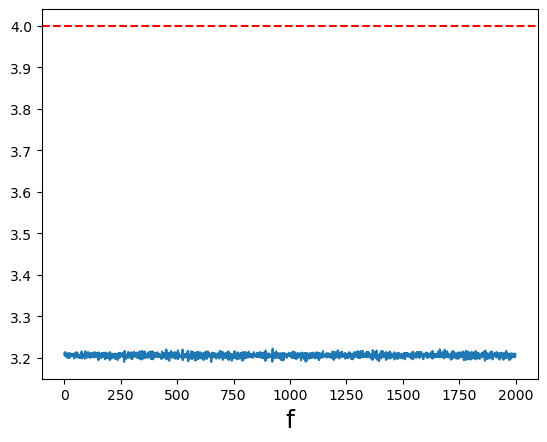

In [169]:
idx = np.random.randint(N_OBJECTS)
plt.plot(mcmc.get_samples()['f'][:, idx])
plt.xlabel('f', fontsize=18)
plt.axhline(4.0, color='r', ls='--')


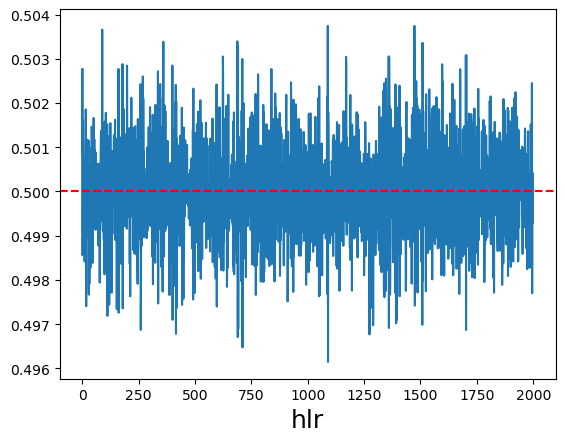

In [110]:
idx = np.random.randint(N_OBJECTS)
plt.plot(mcmc.get_samples()['hlr'][:, idx])
plt.xlabel('hlr', fontsize=18)
plt.axhline(0.5, color='r', ls='--')


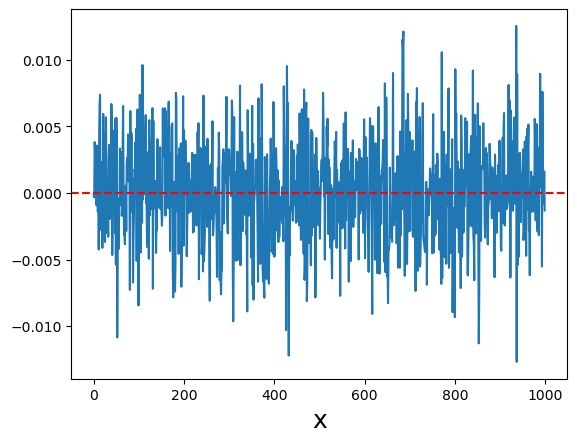

In [33]:
idx = np.random.randint(N_OBJECTS)
plt.plot(mcmc.get_samples()['x'][:, idx])
plt.xlabel('x', fontsize=18)
plt.axhline(0, color='r', ls='--')


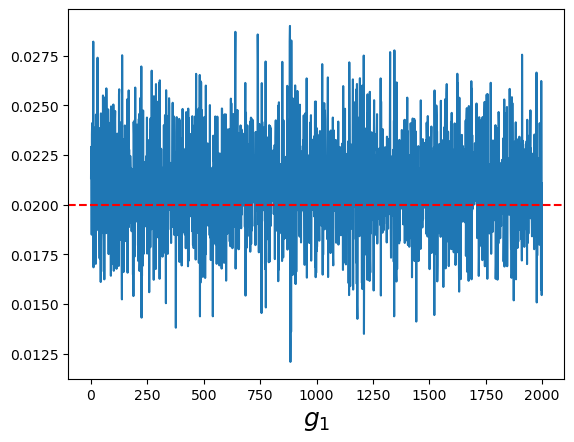

In [171]:
plt.plot(mcmc.get_samples()['g1'])
plt.xlabel('$g_1$', fontsize=18)
plt.axhline(0.02, color='r', ls='--')


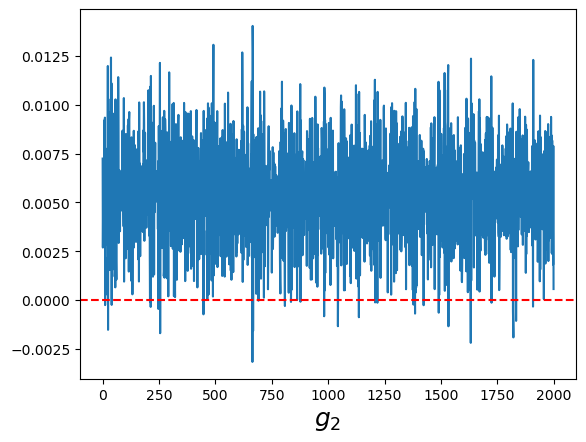

In [172]:
plt.plot(mcmc.get_samples()['g2'])
plt.xlabel('$g_2$', fontsize=18)
plt.axhline(0.00, color='r', ls='--')


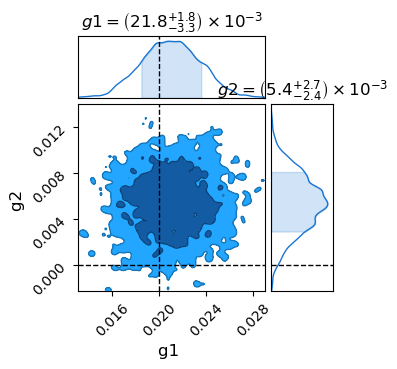

In [170]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth={'g1':0.02, 'g2':0.0})


In [ ]:
mcmc.get_samples()


In [ ]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth={'g1':0.02, 'g2':0.0})


In [253]:
[lists['shifts'][ii]/SCALE for ii in range(5)]


[galsim.PositionD(x=-6.3992809570102915, y=5.185167833526374),
 galsim.PositionD(x=-4.751156193433181, y=9.29614406281224),
 galsim.PositionD(x=22.287919935331097, y=9.090094409841884),
 galsim.PositionD(x=23.209561714366757, y=1.6999117212480819),
 galsim.PositionD(x=-8.817999530889441, y=-13.761420743783631)]

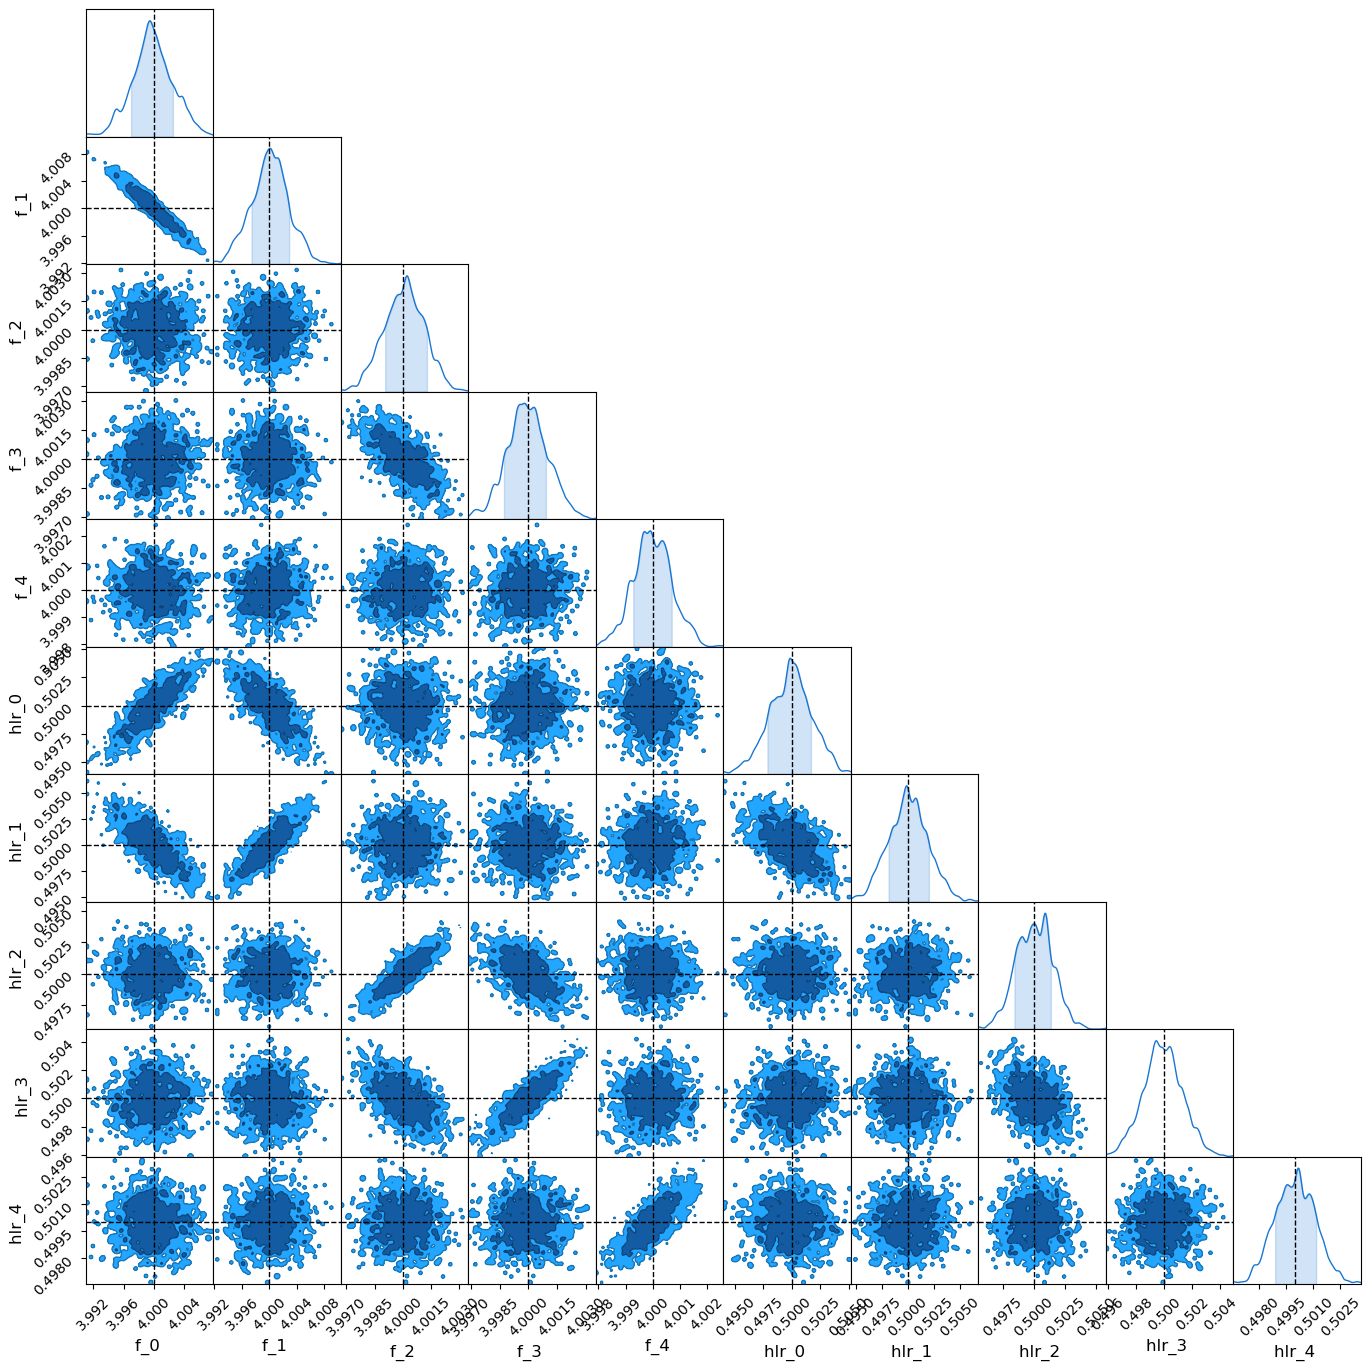

In [256]:
# flux /hlr correlations
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
d1 = {f'f_{ii}':res['f'][:,ii] for ii in range(5)}
d2 = {f'hlr_{ii}':res['hlr'][:,ii] for ii in range(5)}

d1_truth = {f'f_{ii}':4 for ii in range(5)}
d2_truth = {f'hlr_{ii}':0.5 for ii in range(5)}
c.add_chain({**d1, **d2})
fig = c.plotter.plot(truth={**d1_truth, **d2_truth})


## Chi2 test

In [119]:
# chi2 test
from scipy.stats import chi2
from scipy.integrate import quad

n_pix_side = TRUTH_IMAGE.shape[0]
dof = TRUTH_IMAGE.shape[0] * TRUTH_IMAGE.shape[1] - 5 * (1 + 1 + 1 + 1) - 2
samples = mcmc.get_samples()
mean_samples = {k:jnp.mean(v, axis=0) for k,v in samples.items()}
Y = TRUTH_IMAGE - draw_model(mean_samples['x'], mean_samples['y'], mean_samples['hlr'], 10**mean_samples['f'], mean_samples['g1'], mean_samples['g2'])
# Y = np.zeros_like(TRUTH_IMAGE)
inv_cov = np.diag(np.ones(n_pix_side)* (1/1e-3))
chi2_ = np.sum(Y.dot(inv_cov).dot(Y.T))

p_val, _ = quad(lambda x: chi2.pdf(x, 1), chi2_/dof, np.inf)


In [262]:
# chi2 test
from scipy.stats import chi2, norm
from scipy.integrate import quad

n_pix_side = TRUTH_IMAGE.shape[0]
dof = TRUTH_IMAGE.shape[0] * TRUTH_IMAGE.shape[1] - 5 * (1 + 1 + 1 + 1) - 2
samples = mcmc.get_samples()
mean_samples = {k:jnp.mean(v, axis=0) for k,v in samples.items()}
Y = TRUTH_IMAGE - draw_model(mean_samples['x'], mean_samples['y'], mean_samples['hlr'], 10**mean_samples['f'], mean_samples['g1'], mean_samples['g2'])
# Y = np.zeros_like(TRUTH_IMAGE)
inv_cov = np.diag(np.ones(n_pix_side)* (1/1e-3))
chi2_ = np.sum(Y.dot(inv_cov).dot(Y.T))

p_val, _ = quad(lambda x: norm.pdf(x, dof, np.sqrt(2 * dof)), 0, np.inf)


In [261]:
chi2_, dof, chi2_ / dof, p_val


(Array(531.14884993, dtype=float64),
 12299,
 Array(0.04318634, dtype=float64),
 0.0)

In [257]:
# chi2 test
from scipy.stats import chi2, norm
from scipy.integrate import quad, simps

n_pix_side = TRUTH_IMAGE.shape[0]
dof = TRUTH_IMAGE.shape[0] * TRUTH_IMAGE.shape[1] - 5 * (1 + 1 + 1 + 1) - 2
samples = mcmc.get_samples()
mean_samples = {k:jnp.mean(v, axis=0) for k,v in samples.items()}
Y = TRUTH_IMAGE - draw_model(mean_samples['x'], mean_samples['y'], mean_samples['hlr'], 10**mean_samples['f'], mean_samples['g1'], mean_samples['g2'])
# Y = np.zeros_like(TRUTH_IMAGE)
inv_cov = np.diag(np.ones(n_pix_side)* (1/1e-3))
chi2_ = np.sum(Y.dot(inv_cov).dot(Y.T))

x = np.linspace(chi2_, 1e7, int(1e7))
integrand = norm.pdf(x, dof, np.sqrt(2*dof))
p_val = simps(integrand, x)


# p_val, _ = quad(lambda x: norm.pdf(x, dof, np.sqrt(2 * dof)), 0, np.inf, limit=10000)


In [258]:
chi2_, dof, chi2_ / dof, p_val


(Array(531.14884993, dtype=float64),
 12299,
 Array(0.04318634, dtype=float64),
 1.0)

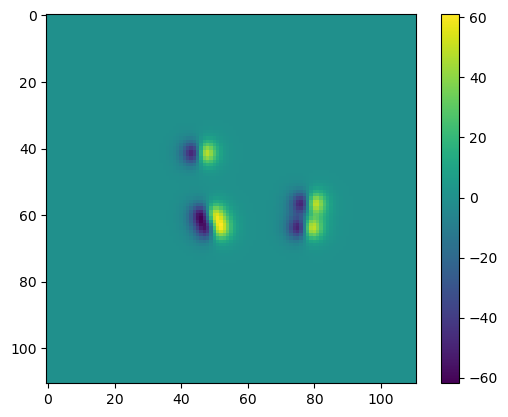

In [244]:
plt.imshow(Y)
plt.colorbar()


(Array(531.14660418, dtype=float64),
 12299,
 Array(0.04318616, dtype=float64),
 1.0000000000000002)

In [135]:
z


Array(-75.03212871, dtype=float64)

In [112]:
quad(lambda x: chi2.pdf(x, 1000), 0, np.inf, limit=1000)


(6.460655811349392e-49, 1.277313440126629e-48)

In [116]:
romberg(lambda x: chi2.pdf(x, 1000), 0, 1e20)


0.0

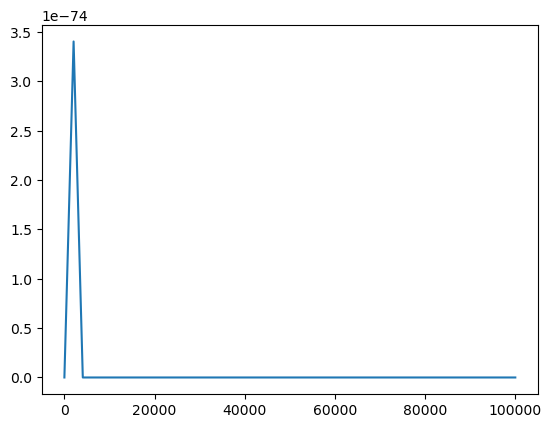

In [111]:
x = np.linspace(0, 1e5) 
y = chi2.pdf(x, 1000) 
plt.plot(x, y)


In [104]:
x


array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
         8.16326531,  10.20408163,  12.24489796,  14.28571429,
        16.32653061,  18.36734694,  20.40816327,  22.44897959,
        24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
        32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
        40.81632653,  42.85714286,  44.89795918,  46.93877551,
        48.97959184,  51.02040816,  53.06122449,  55.10204082,
        57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
        65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
        73.46938776,  75.51020408,  77.55102041,  79.59183673,
        81.63265306,  83.67346939,  85.71428571,  87.75510204,
        89.79591837,  91.83673469,  93.87755102,  95.91836735,
        97.95918367, 100.        ])

In [100]:
chi2_, dof, chi2_ / dof, p_val


(0.0, 12299, 0.0, 0.0)

In [96]:
# chi2 test
from scipy.stats import chi2
from scipy.integrate import quad

xs = jnp.zeros(N_OBJECTS)
ys = jnp.zeros(N_OBJECTS)
hlrs = jnp.array([0.5]*N_OBJECTS)
fluxes = jnp.array([lists['objlist'][0].flux]*N_OBJECTS)
g1 = jnp.array([0.02])
g2 = jnp.array([0.00])

n_pix_side = TRUTH_IMAGE.shape[0]
dof = TRUTH_IMAGE.shape[0] * TRUTH_IMAGE.shape[1] - 5 * (1 + 1 + 1 + 1) - 2
Y_diff = TRUTH_IMAGE - draw_model(xs, ys, hlrs, fluxes, g1, g2)
inv_cov = np.diag(np.ones(n_pix_side)* (1/1e-3))
chi2_ = np.sum(Y.dot(inv_cov).dot(Y.T))

p_val, _ = quad(lambda x: chi2.pdf(x, dof), chi2_, np.inf)


(Array(147.50346258, dtype=float64),
 12299,
 Array(0.01199313, dtype=float64),
 0.0)

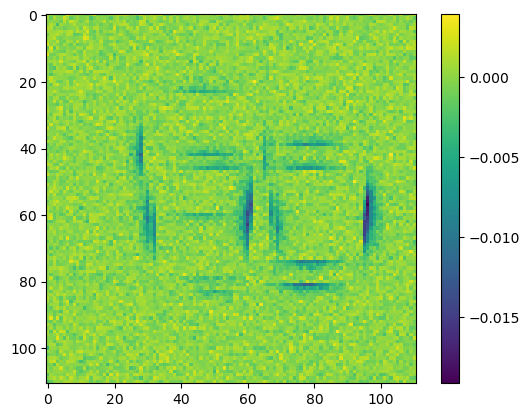

In [89]:
plt.imshow(Y)
plt.colorbar()


In [52]:
samples = mcmc.get_samples()
samples['g1'].shape


(1000,)

In [53]:
samples = mcmc.get_samples()
mean_samples = {k:jnp.mean(v, axis=0) for k,v in samples.items()}


In [54]:
mean_samples


{'f': Array([3.99983018, 4.0001253 , 4.00005726, 3.99994779, 3.99999515],      dtype=float64),
 'g1': Array(0.01997302, dtype=float64),
 'g2': Array(-2.73736094e-06, dtype=float64),
 'hlr': Array([0.49988988, 0.50003662, 0.50004699, 0.49991027, 0.49999731],      dtype=float64),
 'x': Array([3.29054384e-04, 1.94071084e-04, 4.43881630e-05, 6.70390518e-05,
        1.18086877e-04], dtype=float64),
 'y': Array([6.16469329e-04, 7.06939026e-04, 2.29172017e-04, 3.01157638e-04,
        4.09932032e-05], dtype=float64)}

In [55]:
mcmc.get_samples()['f'].shape


(1000, 5)